In [1]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import os
from PyEIS import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import csv
import glob
import statistics
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import math

#from matplotlib.pyplot import rc
#rc('text',usetex=True)
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size='16')
#rc('text.latex', preamble=r'\usepackage{sfmath}')

#set font to Arial
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']


#Put Post-Stabilization Temperature Data into a dataframe
#This file path should go to the *post-stabilization* .txt file that Quincy puts out
file_path = "/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_T_files/Post-Stabilization Temperature Data.txt"
df = pd.read_csv(file_path)

# Define the time column title in the data file as time
Time = 'Time (Day Month Year Hours:Minutes:Seconds AM/PM)'

# Convert the 'Time' column to datetime format
df[Time] = pd.to_datetime(df[Time], format='%d %B %Y %I:%M:%S %p')
#print(df[Time])

#WAS IT DAYLIGHT SAVINGS TIME WHEN YOU COLLECTED YOUR DATA? if yes, set daylight_savings to true. If not, set to false.
daylight_savings=False

if daylight_savings==True:
    #for daylight time (mid March - mid November):
    df['EpochTime'] = ((df[Time] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')) + 21600

if daylight_savings==False:
    # for standard time (mid November - mid March):
    df['EpochTime'] = ((df[Time] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')) + 25200

# Define the target temperatures, these should be whatever temperatures you dwelled at. 
target_temperatures = [30, 35, 45, 55, 65, 75, 85, 95]

# Create a dictionary to store the first and last time for each temperature
temperature_ranges = {temp: {'first_time': None, 'last_time': None} for temp in target_temperatures}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    temperature = row['Oven Temperature (degrees C)']

    # Check if the temperature is within 0.5 degrees of any target temperature
    for target_temp in target_temperatures:
        if abs(temperature - target_temp) <= 0.5:
            if temperature_ranges[target_temp]['first_time'] is None:
                temperature_ranges[target_temp]['first_time'] = row['EpochTime']
            temperature_ranges[target_temp]['last_time'] = row['EpochTime']

# Create a DataFrame from the temperature_ranges dictionary
temperature_ranges_df = pd.DataFrame(temperature_ranges.items(), columns=['Temperature', 'TimeRange'])

# Split the 'TimeRange' column into 'Start' and 'End' columns
temperature_ranges_df[['Start', 'End']] = pd.DataFrame(temperature_ranges_df['TimeRange'].tolist(), index=temperature_ranges_df.index)

# Drop the original 'TimeRange' column
temperature_ranges_df = temperature_ranges_df.drop('TimeRange', axis=1)

# Print the resulting DataFrame
print(temperature_ranges_df)


   Temperature       Start         End
0           30  1732157681  1732161278
1           35  1732166585  1732177657
2           45  1732181096  1732192910
3           55  1732196243  1732208046
4           65  1732211188  1732222702
5           75  1732226060  1732237820
6           85  1732240931  1732252714
7           95  1732255147  1732266874


In [2]:
#INPUT DIAMETER AND HEIGHT OF PELLET HERE!
#diameter in mm
diameter = 6
#pellet height in mm
height = 2.139

#Errors in the thickness and height, generally no need to change this.
#err in pellet diameter (mm)
diameter_err=0.01
#err in pellet height (mm)
height_err=0.001

In [3]:
# Specify the folder path where '.DTA' files are located
# Note that this is the FOLDER with all your .DTA files.
folder_path = "/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_1/"

# Function to list '.DTA' files between specified timestamps
def list_files_between_timestamps(folder_path, start_timestamp, end_timestamp):

    file_list = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a '.DTA' file
        if filename.endswith('.DTA') and os.path.isfile(file_path):
            # Get the file's last modification timestamp
            file_timestamp = os.path.getmtime(file_path)
            #print(start_timestamp, end_timestamp, file_timestamp)
            if start_timestamp <= file_timestamp <= end_timestamp:
                file_list.append(filename)

    return file_list


In [4]:
# Use loc to filter rows based on the temperature value
#start_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['Start']]
#end_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['End']]

# Print the result
#print(start_result)

files_found_dict = {}

#Iterate through target temperatures
for search_temp in target_temperatures:
    start_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['Start']]
    end_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['End']]
        # Assuming start_result and end_result are datetime objects
    start_time = start_result.iloc[0]['Start']
    end_time = end_result.iloc[0]['End']
    # Print intermediate results for troubleshooting
    #print(f"Search Temperature: {search_temp}")
    #print("Start Time:")
    #print(start_time)
    #print("End Time:")
    #print(end_time)
    #YEET the files from between the start and end times into a dictionary
    files_found_dict[search_temp] = list_files_between_timestamps(folder_path, start_time, end_time)
    #print(files_found_dict)
# Print the results
    
print(files_found_dict[30])
    # Print the results for each temperature
    #print(f"Results for Temperature {search_temp}:")
    #print("Start:", start_result.iloc[0]['Start'] if not start_result.empty else "Not found")
    #print("End:", end_result.iloc[0]['End'] if not end_result.empty else "Not found")
    #print()


['EISPOT_#9.DTA', 'EISPOT_#8.DTA', 'EISPOT_#10.DTA', 'EISPOT_#5.DTA', 'EISPOT_#4.DTA', 'EISPOT_#6.DTA', 'EISPOT_#7.DTA']


In [5]:
# Function to extract the numerical part from the filename
def extract_number(filename):
    match = re.search(r'#(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Common parameters for all files

#The values here are the highest frequency and lowest frequency that are included. 
common_params = {
    'mask': [10**7, 10000]}

# Dictionary to store the EIS_exp instances
all_experiments = {}

# Iterate through the keys in files_found_dict
for temp, file_list in files_found_dict.items():
    temp_experiments = {}
    file_list.sort(key=extract_number) #sort the .DTA files in order
    # Iterate through the file list for each temperature
    for idx, filename in enumerate(file_list, start=1):
        #print(filename)
        params = {'path': folder_path, 'data': [filename]}
        params.update(common_params)
        
        
        #var_name = f"Ex{idx}_Temp{temp}"
        
        # Call the EIS_exp function and store the instance in the dictionary, dictionary has two keys
        temp_experiments[idx] = EIS_exp(**params)
    
        # Store the experiments for each temperature in the overall dictionary
        #this generates the 'all_experiments' dictionary with a two part key. The first part of the key is the temperature, while the second part of the key is the replicate at that temperature.
        all_experiments[temp,idx] = temp_experiments[idx]

# Print the resulting dictionary of experiments
#print(all_experiments)

In [6]:
#In order to fit the experimental data, a parameter space is needed for the EIS_fit() function with initial guesses
#for each parameter including lower and upper bounds.
#You may want to rerun this step until the data fits well.
#Adjusting starting parameters to match your data will give the best results

#If this section is confusing to you or you are struggling with equivalent circuit modeling, check out:
#DOI: 10.1021/acsmeasuresciau.2c00070
#DOI: 10.1002/celc.202100108

#do you want to do a sequential fit where the results of the previous fit are used as the starting values for the next one?
#This is particularly useful for temperature dependent datasets to allow for the parameter drift over different temperatures
sequentialfit='yes'
params= Parameters() #creates the parameter space
#the following guesses will need to be adjusted based on your data as well as the equivalent circuit to be fit
#the following equivalent circuit is the Rs_(RQ)1_Q circuit

#Rs_guess is the leading resistor that accounts for the resistance of our leads and equipment
#This is generally 0 or close to 0 for Austin's samples. 
#If your whole semicircle is visible, a good starting value is where the left hand side of the semicircle touches down on the z-real axis
Rs_guess = 0
params.add('Rs', value=Rs_guess, min=0, max=1)

#R1_guess is the bulk resistance that is in the RQ element
#A good starting guess is where the right side of your semicircle comes closest to the z-real axis.
R1_guess = 5000
params.add('R1', value=R1_guess, min=0, max=10**10)

#n1_guess represents the ideality of your semicircle
#if it's squashed, use a lower starting value, if it's gorgeous, use a value closer to 1
n1_guess = 0.7
params.add('n1', value=n1_guess, min=0.6, max=1) #do not change min max values of n otherwise they become meaningless

#fs1_guess represents the characteristic frequency for the semicircle
#this is the frequency corresponding to the maximum z-imaginary value for your semicircle
fs1_guess = 9000000
params.add('fs1', value=fs1_guess, min=fs1_guess*.001, max=fs1_guess*100)

#n_guess and Q-guess represent the ideality of the capacitor-like behavior of the capacitive tail
n_guess = 0.7
params.add('n', value=n1_guess, min=0.6, max=1) #do not change min max values of n otherwise they become meaningless
Q_guess = 10**-7
params.add('Q', value=Q_guess, min=Q_guess*0.001, max=Q_guess*1000)

#code below actually does the fit, change the circuit to what you need with circuit = ''
#experiments['Ex1'].EIS_fit(params=params, circuit='R-RQ-Q')
# Dictionary to store fit results
fit_results = {}

# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in all_experiments.items():
    temp_fit_results = {}

    # Iterate through the inner dictionary (individual experiments for each temperature)
    #for exp_name, exp_instance in temp_experiments.items():
    fit_result = exp_instance.EIS_fit(params=params, circuit='R-RQ-Q')
    temp_fit_results[key] = fit_result
    print(f'Start R1 value for temp {key[0]}C, replicate {key[1]}:', params['R1'].value)
    print(f'Refined R1 value for temp {key[0]}C, replicate {key[1]}:', exp_instance.fit_R1[0])
    if sequentialfit == 'yes':
        params['Rs'].value = exp_instance.fit_Rs[0]
        params['R1'].value = exp_instance.fit_R1[0]
        params['n1'].value = exp_instance.fit_n1[0]
        params['fs1'].value = exp_instance.fit_fs1[0]
        params['n'].value = exp_instance.fit_n[0]
        params['Q'].value = exp_instance.fit_Q[0]
    # Store the fit results for each temperature
    fit_results[key] = temp_fit_results

# Print the overall fit results
print(fit_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 222
    # data points      = 46
    # variables        = 6
    chi-square         = 0.60177123
    reduced chi-square = 0.01504428
    Akaike info crit   = -187.479888
    Bayesian info crit = -176.508040
[[Variables]]
    Rs:   0.15923287 +/- 1958.08168 (1229696.90%) (init = 0)
    R1:   4535.54238 +/- 1.39123177 (0.03%) (init = 5000)
    n1:   0.79744815 +/- 0.00545508 (0.68%) (init = 0.7)
    fs1:  3774711.67 +/- 38567.8771 (1.02%) (init = 9000000)
    n:    0.81017952 +/- 0.03487020 (4.30%) (init = 0.7)
    Q:    1.6750e-07 +/- 6.5552e-08 (39.13%) (init = 1e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9993
    C(Rs, n)   = -0.8368
    C(Rs, Q)   = +0.8303
    C(Rs, n1)  = +0.8109
    C(fs1, n)  = -0.6226
    C(fs1, Q)  = +0.6202
    C(n1, n)   = -0.6107
    C(n1, Q)   = +0.6019
    C(Rs, fs1) = +0.5400
    C(R1, n)   = +0.3315
    C(R1, Q)   = -0.3306
    C(R1, fs1) = -0.

    C(R1, n)   = -0.1527
None
Start R1 value for temp 35C, replicate 7: 4063.2511372207246
Refined R1 value for temp 35C, replicate 7: 4041.748496441677
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 46
    # variables        = 6
    chi-square         = 2.80002477
    reduced chi-square = 0.07000062
    Akaike info crit   = -116.754604
    Bayesian info crit = -105.782756
[[Variables]]
    Rs:   0.99999735 +/- 12.1827013 (1218.27%) (init = 0.5904788)
    R1:   4038.87969 +/- 4.14892982 (0.10%) (init = 4041.748)
    n1:   0.81553120 +/- 0.00934480 (1.15%) (init = 0.809921)
    fs1:  4178300.06 +/- 63421.4256 (1.52%) (init = 4240955)
    n:    0.82164137 +/- 0.01735704 (2.11%) (init = 0.8236551)
    Q:    1.4876e-07 +/- 2.9333e-08 (19.72%) (init = 1.493176e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9941
    C(Rs, n)   = +0.8528
    C(Rs, Q)   = -0.8219
    C(Rs, n1)  = -0.7771
    C(n1, n)   =

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 156
    # data points      = 46
    # variables        = 6
    chi-square         = 0.27910896
    reduced chi-square = 0.00697772
    Akaike info crit   = -222.820544
    Bayesian info crit = -211.848696
[[Variables]]
    Rs:   0.00373556 +/- 24.4747317 (655182.39%) (init = 2.890835e-07)
    R1:   2735.67010 +/- 0.83720839 (0.03%) (init = 2788.799)
    n1:   0.78308815 +/- 0.00523909 (0.67%) (init = 0.798485)
    fs1:  6208367.78 +/- 67155.3019 (1.08%) (init = 6048163)
    n:    0.85400830 +/- 0.01540391 (1.80%) (init = 0.846865)
    Q:    1.2196e-07 +/- 2.0977e-08 (17.20%) (init = 1.312937e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9976
    C(Rs, n)   = +0.8447
    C(Rs, Q)   = -0.8318
    C(Rs, n1)  = -0.7962
    C(Rs, R1)  = -0.6795
    C(n1, n)   = -0.6430
    C(n1, Q)   = +0.6291
    C(R1, n)   = -0.4491
    C(R1, Q)   = +0.4411
    C(R1, n1)  = +0.4218
    C(fs1, n) 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 282
    # data points      = 46
    # variables        = 6
    chi-square         = 0.59128493
    reduced chi-square = 0.01478212
    Akaike info crit   = -188.288538
    Bayesian info crit = -177.316690
[[Variables]]
    Rs:   3.9121e-04 +/- 1.3742e+10 (3512559998907036.50%) (init = 4.173389e-07)
    R1:   2387.93005 +/- 1.26812420 (0.05%) (init = 2404.462)
    n1:   0.77222467 +/- 0.00762747 (0.99%) (init = 0.7663364)
    fs1:  7241869.50 +/- 113583.086 (1.57%) (init = 7271134)
    n:    0.88759796 +/- 0.01393624 (1.57%) (init = 0.885934)
    Q:    8.6989e-08 +/- 1.4071e-08 (16.18%) (init = 8.85078e-08)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9923
    C(Rs, n)   = +0.8789
    C(Rs, Q)   = -0.8470
    C(Rs, R1)  = -0.7734
    C(Rs, n1)  = -0.7121
    C(R1, n)   = -0.6483
    C(R1, Q)   = +0.6304
    C(n1, n)   = -0.5777
    C(n1, Q)   = +0.5385
    C(R1, n1)  = +0.3636
    

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 46
    # variables        = 6
    chi-square         = 0.20693719
    reduced chi-square = 0.00517343
    Akaike info crit   = -236.583142
    Bayesian info crit = -225.611294
[[Variables]]
    Rs:   9.0248e-05 +/- 3.91804124 (4341411.02%) (init = 0.0003727954)
    R1:   1547.81687 +/- 0.59189590 (0.04%) (init = 1576.938)
    n1:   0.75115165 +/- 0.01074607 (1.43%) (init = 0.7344581)
    fs1:  12099809.5 +/- 273465.849 (2.26%) (init = 1.213141e+07)
    n:    0.87671268 +/- 0.00888250 (1.01%) (init = 0.8723901)
    Q:    1.0826e-07 +/- 1.1181e-08 (10.33%) (init = 1.159781e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9895
    C(Rs, n)   = +0.8816
    C(Rs, Q)   = -0.8390
    C(Rs, n1)  = -0.7999
    C(Rs, R1)  = -0.7578
    C(R1, n)   = -0.6570
    C(n1, n)   = -0.6519
    C(n1, fs1) = -0.6291
    C(R1, Q)   = +0.6275
    C(n1, Q)   = +0.6097
    C(

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 177
    # data points      = 46
    # variables        = 6
    chi-square         = 0.70575338
    reduced chi-square = 0.01764383
    Akaike info crit   = -180.148018
    Bayesian info crit = -169.176169
[[Variables]]
    Rs:   2.1112e-08 +/- 1549705.67 (7340451634255630.00%) (init = 0.9991065)
    R1:   1037.89434 +/- 0.61957058 (0.06%) (init = 1050.278)
    n1:   0.61716342 +/- 0.01217511 (1.97%) (init = 0.642592)
    fs1:  27863030.3 +/- 1745158.65 (6.26%) (init = 2.575463e+07)
    n:    0.89367356 +/- 0.01133238 (1.27%) (init = 0.889143)
    Q:    1.0474e-07 +/- 1.4068e-08 (13.43%) (init = 1.069741e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9917
    C(n1, fs1) = -0.8399
    C(Rs, n)   = -0.6841
    C(Rs, Q)   = +0.6552
    C(Rs, n1)  = +0.4374
    C(Rs, R1)  = +0.3260
    C(R1, fs1) = +0.2341
    C(R1, n1)  = -0.1655
    C(n1, n)   = -0.1486
    C(n1, Q)   = +0.1299
No

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 451
    # data points      = 46
    # variables        = 6
    chi-square         = 0.38432996
    reduced chi-square = 0.00960825
    Akaike info crit   = -208.105181
    Bayesian info crit = -197.133332
##  Warning: uncertainties could not be estimated:
    Rs:   at boundary
    n1:   at boundary
    Q:    at initial value
[[Variables]]
    Rs:   1.5417e-11 (init = 0.09334241)
    R1:   647.837113 (init = 657.8934)
    n1:   0.60000000 (init = 0.6001256)
    fs1:  46186050.3 (init = 4.978951e+07)
    n:    0.89948995 (init = 0.8972506)
    Q:    1.1128e-07 (init = 1.121946e-07)
None
Start R1 value for temp 75C, replicate 2: 657.8933958722998
Refined R1 value for temp 75C, replicate 2: 647.8371128437743
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 46
    # variables        = 6
    chi-square         = 4.67931004
    reduced chi-square = 0.11698275
  

    C(R1, fs1) = -0.2713
None
Start R1 value for temp 75C, replicate 15: 587.5439151870055
Refined R1 value for temp 75C, replicate 15: 586.798662993715
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 46
    # variables        = 6
    chi-square         = 0.39360473
    reduced chi-square = 0.00984012
    Akaike info crit   = -207.008277
    Bayesian info crit = -196.036429
[[Variables]]
    Rs:   1.9234e-08 +/- 2.37325796 (12338806609.52%) (init = 0.0007096641)
    R1:   586.000050 +/- 0.54634941 (0.09%) (init = 586.7987)
    n1:   0.60000038 +/- 0.03395374 (5.66%) (init = 0.6014007)
    fs1:  51064364.6 +/- 9484895.62 (18.57%) (init = 5.067003e+07)
    n:    0.90211256 +/- 0.01074182 (1.19%) (init = 0.9020115)
    Q:    1.1290e-07 +/- 1.3737e-08 (12.17%) (init = 1.127024e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9941
    C(n1, fs1) = -0.9366
    C(Rs, n)   = +0.8958
    C(Rs, n1)  = -0.8855

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 367
    # data points      = 46
    # variables        = 6
    chi-square         = 0.01194749
    reduced chi-square = 2.9869e-04
    Akaike info crit   = -367.770269
    Bayesian info crit = -356.798421
[[Variables]]
    Rs:   0.17287435 +/- 8.2750e+10 (47867228032325.92%) (init = 1.544703e-11)
    R1:   436.905414 +/- 0.08693271 (0.02%) (init = 455.9139)
    n1:   0.60000095 +/- 1943128.24 (323854192.71%) (init = 0.6)
    fs1:  1.0252e+08 +/- 36030531.8 (35.14%) (init = 8.090396e+07)
    n:    0.85654091 +/- 0.00709429 (0.83%) (init = 0.8545312)
    Q:    2.0618e-07 +/- 1.6880e-08 (8.19%) (init = 2.117447e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9958
    C(n1, fs1) = -0.9795
    C(Rs, n1)  = +0.9202
    C(Rs, fs1) = -0.8346
    C(Rs, n)   = -0.7203
    C(Rs, Q)   = +0.6907
    C(n1, n)   = -0.5947
    C(n1, Q)   = +0.5658
    C(fs1, n)  = +0.5109
    C(Rs, R1)  = +0.49

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 358
    # data points      = 46
    # variables        = 6
    chi-square         = 0.00315915
    reduced chi-square = 7.8979e-05
    Akaike info crit   = -428.960335
    Bayesian info crit = -417.988487
[[Variables]]
    Rs:   8.0938e-07 +/- 2429.73918 (300198196773.48%) (init = 0.004407174)
    R1:   318.109390 +/- 0.02943770 (0.01%) (init = 386.7841)
    n1:   0.60117784 +/- 6.1950e+09 (1030484135227.72%) (init = 0.6)
    fs1:  2.6622e+08 +/- 66724122.8 (25.06%) (init = 1.083115e+08)
    n:    0.84637179 +/- 0.00338876 (0.40%) (init = 0.8681644)
    Q:    2.6000e-07 +/- 1.0097e-08 (3.88%) (init = 1.909074e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9948
    C(n1, fs1) = +0.9846
    C(Rs, n)   = +0.9070
    C(Rs, n1)  = +0.8903
    C(Rs, Q)   = -0.8835
    C(Rs, fs1) = +0.8394
    C(n1, n)   = +0.7616
    C(n1, Q)   = -0.7375
    C(fs1, n)  = +0.7071
    C(fs1, Q)  = -0.6

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3891
    # data points      = 46
    # variables        = 6
    chi-square         = 0.02268497
    reduced chi-square = 5.6712e-04
    Akaike info crit   = -338.275929
    Bayesian info crit = -327.304080
##  Warning: uncertainties could not be estimated:
    Q:    at initial value
[[Variables]]
    Rs:   2.8944e-07 (init = 3.122834e-08)
    R1:   280.716981 (init = 302.1622)
    n1:   0.61062926 (init = 0.6002765)
    fs1:  1.4034e+08 (init = 1.711038e+08)
    n:    0.86315407 (init = 0.8568732)
    Q:    2.3469e-07 (init = 2.384512e-07)
None
Start R1 value for temp 95C, replicate 14: 302.162237453274
Refined R1 value for temp 95C, replicate 14: 280.71698077170026
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 46
    # variables        = 6
    chi-square         = 0.12488056
    reduced chi-square = 0.00312201
    Akaike info crit   = -259.815791
    

In [7]:
#plot individual data with fitting
#The below example plots all of the replicates at 30C
# plt.figure(figsize=(6,6))
# for key, exp_instance in all_experiments.items():
#     if key[0]==30:
#         all_experiments[key].EIS_plot(fitting='on')
    
#all_experiments[30]['Ex7_Temp30'].EIS_plot(fitting='on')
#xdownlim=0
#uplim=40000
#plt.ylim(0,uplim)
#plt.xlim(xdownlim,uplim)

#plt.show()

In [8]:
#Here we load in the optimized values for R1 and the characteristic frequency into discrete dictionaries

R1_opt = {}
Fs1_opt={}
# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in all_experiments.items():
    # Iterate through the inner dictionary (individual experiments for each temperature)
        R1_optm = float(exp_instance.fit_R1[0])
        R1_opt[key] = R1_optm
        Fs1_optm= float(exp_instance.fit_fs1[0])
        Fs1_opt[key]=Fs1_optm

print(R1_opt)
print(Fs1_opt)

{(30, 1): 4535.542383887759, (30, 2): 4592.250745227844, (30, 3): 4696.965675843323, (30, 4): 4774.415819364109, (30, 5): 4806.367699949909, (30, 6): 4920.602061364576, (30, 7): 4977.083781776415, (35, 1): 4077.5315324204084, (35, 2): 4077.932565516029, (35, 3): 4076.409357289812, (35, 4): 4074.822505528708, (35, 5): 4071.6956961617257, (35, 6): 4063.2511372207246, (35, 7): 4041.748496441677, (35, 8): 4038.8796856971608, (35, 9): 4038.8796856971608, (35, 10): 4036.540982577108, (35, 11): 4031.968126594343, (35, 12): 4031.680260196957, (35, 13): 4028.2828489557332, (35, 14): 4027.1475565401006, (35, 15): 4027.1475565401006, (35, 16): 4027.1475565401006, (35, 17): 4024.720108297686, (35, 18): 4022.996106800569, (35, 19): 4021.48070899333, (35, 20): 4014.368155114134, (45, 1): 2849.171745755719, (45, 2): 2788.7986170371805, (45, 3): 2735.6700987857253, (45, 4): 2674.6046805081746, (45, 5): 2616.00884954305, (45, 6): 2568.055068596919, (45, 7): 2533.091471024207, (45, 8): 2505.588205248265

In [9]:
#here we make a bunch of dataframes for nyquist plots
#samplename and materialname are included in output files, so change them as appropriate
samplename='2_089_1'
materialname='Li$_6$PS$_5$CN'

#in this cell, we generate simulated data for each nyquist plot so as to be able to export experimental and modeled values
#for temperature dependent nyquist plots

#generates a frequency range for any simulations
f_range = freq_gen(f_start=(2*10**6), f_stop=0.2, pts_decade=10)
print(f_range[0][:4]) #First 5 points in the freq. array
print()
print(f_range[1][:4]) #First 5 points in the angular freq. array


#This chunk of code generates a simulated dataset using the parameters from the initial modelling above
sim={}
# Iterate through the outer dictionary (temperature-wise experiments)
for exp_name, exp_instance in all_experiments.items():
    sim_temp= cir_RsRQQ(w=f_range[1], Rs=float(exp_instance.fit_Rs[0]), R1=float(exp_instance.fit_R1[0]), n1=float(exp_instance.fit_n1[0]), Q1=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0]), n=float(exp_instance.fit_n[0]), Q=float(exp_instance.fit_Q[0]))
    sim[exp_name]=sim_temp

nyquist={}
# Iterate through the outer dictionary (temperature-wise experiments)
for exp_name, exp_instance in all_experiments.items():
     # Find the minimum length among the arrays for this experiment
    min_length = min(len(exp_instance.df_raw.re), len(exp_instance.df_raw.im), len(sim[exp_name].real), len(sim[exp_name].imag),len(exp_instance.df_raw.f))
    exp_name_temp=[exp_name]*min_length
    #samplenamez=[samplename]*min_length
    #materialnamez=[materialname]*min_length
    # Truncate arrays to the minimum length
    truncated_re = exp_instance.df_raw.re[:min_length]
    truncated_im = exp_instance.df_raw.im[:min_length]
    truncated_f= exp_instance.df_raw.f[:min_length]
    truncated_fit_real = sim[exp_name].real[:min_length]
    truncated_fit_imag = -sim[exp_name].imag[:min_length]
    
    # Create DataFrame with truncated arrays
    nyquist[exp_name] = pd.DataFrame({
        'Frequency':truncated_f,
        'Z real': truncated_re,
        'Z imag': truncated_im,
        'Fit real': truncated_fit_real,
        'Fit imag': truncated_fit_imag,
        'Dataset':exp_name_temp,
        #'sample_name':samplenamez,
        #'material_name':materialnamez
    })
    print(nyquist[exp_name])

[2000000.         1583363.8318526  1253520.51200948  992389.52060058]

[12566370.61435917  9948568.36421585  7876101.66330618  6235367.25483656]
       Frequency       Z real       Z imag      Fit real      Fit imag  \
0   2.000039e+06     3103.110     1490.523  3.101043e+03  1.501896e+03   
1   1.588711e+06     3346.601     1380.998  3.359539e+03  1.390687e+03   
2   1.261992e+06     3551.792     1276.774  3.583047e+03  1.263610e+03   
3   1.002539e+06     3758.580     1131.506  3.771118e+03  1.130374e+03   
4   7.962891e+05     3905.490     1035.630  3.926103e+03  9.988977e+02   
..           ...          ...          ...           ...           ...   
65  6.334459e-01   916217.500  2315742.000  6.881968e+05  2.224507e+06   
66  5.029507e-01  1112558.000  2746242.000  8.306364e+05  2.687979e+06   
67  3.999573e-01  1345211.000  3249524.000  1.002753e+06  3.248015e+06   
68  3.175813e-01  1622387.000  3843123.000  1.210730e+06  3.924733e+06   
69  2.520161e-01  1953819.000  4549376.00

[70 rows x 6 columns]
       Frequency       Z real        Z imag      Fit real      Fit imag  \
0   2.000039e+06     2201.836  7.742849e+02  2.205786e+03  7.741673e+02   
1   1.588711e+06     2295.262  7.099209e+02  2.320860e+03  6.915954e+02   
2   1.261992e+06     2405.215  6.203733e+02  2.415515e+03  6.101799e+02   
3   1.002539e+06     2483.271  5.545679e+02  2.492212e+03  5.334087e+02   
4   7.962891e+05     2546.693  4.673679e+02  2.553764e+03  4.634826e+02   
..           ...          ...           ...           ...           ...   
65  6.334459e-01   888682.100  2.650682e+06  6.805572e+05  2.763095e+06   
66  5.029507e-01  1102987.000  3.169184e+06  8.288175e+05  3.367516e+06   
67  3.999573e-01  1362338.000  3.773390e+06  1.009509e+06  4.104153e+06   
68  3.175813e-01  1680977.000  4.493387e+06  1.229727e+06  5.001927e+06   
69  2.520161e-01  2069378.000  5.342908e+06  1.498118e+06  6.096088e+06   

    Dataset  
0   (45, 2)  
1   (45, 2)  
2   (45, 2)  
3   (45, 2)  
4   (45

[70 rows x 6 columns]
       Frequency       Z real        Z imag      Fit real      Fit imag  \
0   2.000039e+06     1903.700  5.930055e+02  1.895101e+03  5.742376e+02   
1   1.588711e+06     1975.379  5.296077e+02  1.977042e+03  5.135551e+02   
2   1.261992e+06     2047.511  4.616690e+02  2.045309e+03  4.548402e+02   
3   1.002539e+06     2113.694  3.964080e+02  2.101569e+03  3.999941e+02   
4   7.962891e+05     2138.421  3.483728e+02  2.147613e+03  3.502123e+02   
..           ...          ...           ...           ...           ...   
65  6.334459e-01   838049.800  2.669256e+06  7.162663e+05  4.214206e+06   
66  5.029507e-01  1041349.000  3.202984e+06  8.818965e+05  5.191905e+06   
67  3.999573e-01  1288835.000  3.830052e+06  1.085953e+06  6.396432e+06   
68  3.175813e-01  1594715.000  4.581435e+06  1.337351e+06  7.880410e+06   
69  2.520161e-01  1969934.000  5.472558e+06  1.647073e+06  9.708672e+06   

     Dataset  
0   (45, 21)  
1   (45, 21)  
2   (45, 21)  
3   (45, 21)  
4 

[70 rows x 6 columns]
       Frequency        Z real        Z imag      Fit real      Fit imag  \
0   2.000039e+06  8.139838e+02  1.183266e+02  8.560242e+02  1.239463e+02   
1   1.588711e+06  8.243259e+02  1.032269e+02  8.714799e+02  1.124901e+02   
2   1.261992e+06  8.334694e+02  8.956013e+01  8.850075e+02  1.021354e+02   
3   1.002539e+06  8.385162e+02  7.886395e+01  8.968366e+02  9.297498e+01   
4   7.962891e+05  8.429592e+02  6.689746e+01  9.071847e+02  8.507874e+01   
..           ...           ...           ...           ...           ...   
65  6.334459e-01  7.039056e+05  2.076699e+06  5.545983e+05  3.682852e+06   
66  5.029507e-01  8.681690e+05  2.483301e+06  6.849301e+05  4.549848e+06   
67  3.999573e-01  1.067095e+06  2.961862e+06  8.459440e+05  5.620949e+06   
68  3.175813e-01  1.311635e+06  3.532164e+06  1.044863e+06  6.944202e+06   
69  2.520161e-01  1.610199e+06  4.203044e+06  1.290610e+06  8.578968e+06   

     Dataset  
0   (65, 11)  
1   (65, 11)  
2   (65, 11)  
3   (

[70 rows x 6 columns]
       Frequency        Z real        Z imag      Fit real      Fit imag  \
0   2.000039e+06  5.433975e+02  5.536735e+01  5.503007e+02  6.150086e+01   
1   1.588711e+06  5.482604e+02  5.016526e+01  5.573933e+02  5.591723e+01   
2   1.261992e+06  5.503127e+02  4.402995e+01  5.635976e+02  5.110323e+01   
3   1.002539e+06  5.533188e+02  3.988562e+01  5.690363e+02  4.708888e+01   
4   7.962891e+05  5.560779e+02  3.615099e+01  5.738220e+02  4.390452e+01   
..           ...           ...           ...           ...           ...   
65  6.334459e-01  6.297451e+05  1.815771e+06  4.868455e+05  3.039862e+06   
66  5.029507e-01  7.752018e+05  2.168903e+06  6.004748e+05  3.750241e+06   
67  3.999573e-01  9.509720e+05  2.584120e+06  7.406579e+05  4.626628e+06   
68  3.175813e-01  1.166184e+06  3.077900e+06  9.136002e+05  5.707816e+06   
69  2.520161e-01  1.428555e+06  3.659207e+06  1.126957e+06  7.041665e+06   

     Dataset  
0   (75, 11)  
1   (75, 11)  
2   (75, 11)  
3   (

[70 rows x 6 columns]
       Frequency        Z real        Z imag       Fit real      Fit imag  \
0   2.000039e+06  3.799046e+02  2.825392e+01     391.083784  3.162704e+01   
1   1.588711e+06  3.815641e+02  2.631004e+01     394.403247  2.917761e+01   
2   1.261992e+06  3.832266e+02  2.385994e+01     397.343077  2.725841e+01   
3   1.002539e+06  3.849032e+02  2.237642e+01     399.968409  2.588581e+01   
4   7.962891e+05  3.860004e+02  2.104686e+01     402.339415  2.508422e+01   
..           ...           ...           ...            ...           ...   
65  6.334459e-01  5.419053e+05  1.554855e+06  397646.901631  1.797173e+06   
66  5.029507e-01  6.659392e+05  1.858133e+06  486200.176016  2.197808e+06   
67  3.999573e-01  8.162713e+05  2.214257e+06  594494.203911  2.687755e+06   
68  3.175813e-01  1.001225e+06  2.635604e+06  726929.696135  3.286923e+06   
69  2.520161e-01  1.225943e+06  3.137697e+06  888888.392708  4.019661e+06   

     Dataset  
0   (85, 12)  
1   (85, 12)  
2   (85,

[70 rows x 6 columns]
       Frequency       Z real        Z imag       Fit real      Fit imag  \
0   2.000039e+06     263.0669  1.348511e+01     267.138232  1.818355e+01   
1   1.588711e+06     263.9227  1.370683e+01     268.933838  1.704613e+01   
2   1.261992e+06     264.6643  1.307610e+01     270.541194  1.626440e+01   
3   1.002539e+06     265.6583  1.280073e+01     271.997580  1.585488e+01   
4   7.962891e+05     266.5194  1.298399e+01     273.338015  1.584215e+01   
..           ...          ...           ...            ...           ...   
65  6.334459e-01  419551.3000  1.179219e+06  332904.948724  1.538052e+06   
66  5.029507e-01  513531.2000  1.408056e+06  407331.027972  1.882196e+06   
67  3.999573e-01  627077.9000  1.677372e+06  498410.162366  2.303343e+06   
68  3.175813e-01  765919.6000  1.998207e+06  609868.522225  2.818723e+06   
69  2.520161e-01  935261.8000  2.378497e+06  746266.019487  3.449420e+06   

     Dataset  
0   (95, 20)  
1   (95, 20)  
2   (95, 20)  
3   (

In [10]:
#Define functions

#function to generate a list of files from the target directory
def file_dict(file_DIR):
    ext = ('*.csv')
    list_files = glob.glob(os.path.join(file_DIR, ext))
    return list_files

#function to generate a list of colors in hex format using start color, end color, and the target folder(directory) length
def color_gradient(startcolor,endcolor,temperatures):
    color_list = list(startcolor.range_to(endcolor, len(temperatures)))
    datacolor = {}
    for temp, color in zip(sorted(temperatures), color_list):
        datacolor[temp] = color.hex
    return datacolor

#This is a function whose only purpose is to extract the replicate number from the dataset name
def extract_temp_replicate(string):
    temp_match = re.search(r'temp_(\d+)_', string)
    if temp_match:
        temp_match=int(temp_match.group(1))
    else:
        return None
    replicate_match=re.search(r'replicate_(\d+)_', string)
    if replicate_match:
        replicate_match=int(replicate_match.group(1))
    else:
        return None
    return temp_match, replicate_match

#generate a marker for each temperature
def make_markers(marker_types,unique_temperatures):
    markers={}
    markers=marker_types * (len(unique_temperatures) // len(marker_types)) + marker_types[:len(unique_temperatures) % len(marker_types)]
    tempmarkers={}
    for i, temp in enumerate(sorted(unique_temperatures)):
        marker_index = i % len(markers)  # Calculate marker index based on the position of temperature
        tempmarkers[temp] = markers[marker_index]
    return tempmarkers

# Define a function to format the axis multiplier
def format_axis(value, tick_number, limit):
    if limit >= 1e9:
        value = value / 1e9
    elif limit >= 1e6:
        value = value / 1e6
    elif limit >= 3e3:
        value = value / 1e3
    return '{:.0f}'.format(value)

# Define a function to format the axis label unit
def labelprefix(limit):
    prefix = ''
    if limit >= 1e9:
        prefix = 'G'
    elif limit >= 1e6:
        prefix = 'M'
    elif limit >= 3e3:
        prefix = 'k'
    return prefix

#goes to the first csf and grabs the first entry in the material name column
def getmaterialname(filelist):
    firstdataframe=pd.read_csv(filelist[0])
    materialname=firstdataframe.at[0,'material_name']
    return materialname

#goes to the first csf and grabs the first entry in the sample name column
def getsamplename(filelist):
    firstdataframe=pd.read_csv(filelist[0])
    samplename=firstdataframe.at[0,'sample_name']
    return samplename

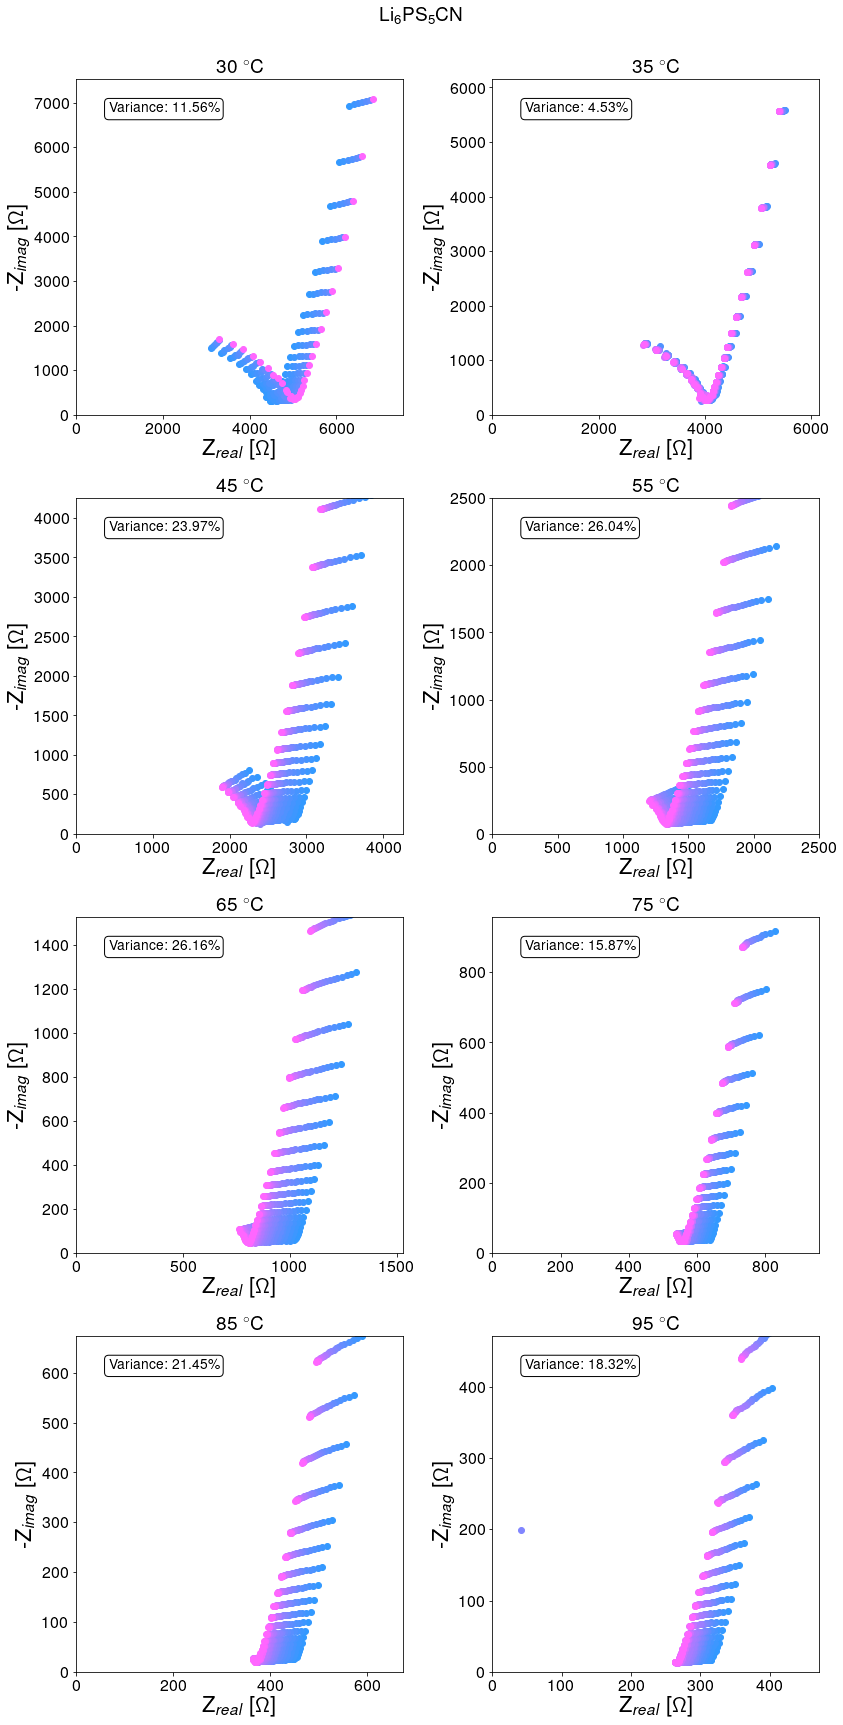

In [11]:
#This cell generates temperature dependent nyquist plots and tracks the variance between the maximum and minimum R1 values
#This is so you can see whether there is systematic drift due to equilibriation

from collections import defaultdict
import math
import matplotlib.colors as mcolors
from matplotlib.pyplot import rc

rc('text',usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size='16')
rc('text.latex', preamble=r'\usepackage{sfmath}')
# Create a colormap

cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#3399ff", "#ff66ff"])

# Normalize the key[1] values
all_keys = [key[1] for key in nyquist.keys()]
norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

# Group the DataFrames by the first element of their keys
grouped_nyquist = defaultdict(list)
for key, df in nyquist.items():
    grouped_nyquist[key[0]].append((key, df))

# Sort dataframes in each group by key[1]
for group_key in grouped_nyquist:
    grouped_nyquist[group_key].sort(key=lambda x: x[0][1])

# Create subplots in a 2-column layout
num_plots = len(grouped_nyquist)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
figsize = (12, 6 * num_rows)
fig0, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

# Store variance results
variance_results = {}

# Loop through each group and plot
for ax, (group_key, dataframes) in zip(axes, grouped_nyquist.items()):
    z_real_at_min_z_imag = {}
    
    for i, (key, df) in enumerate(dataframes):
        if i == len(dataframes) - 1:
            color = "#ff66ff"
        else:
            color = cmap(norm(key[1]))
        ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color)
        
        # Find index of minimum value in 'Z imag'
        min_index = df['Z imag'].idxmin()
        z_real_at_min_z_imag[key] = df.loc[min_index, 'Z real']
    
    # Calculate percent variance
    var = ((max(z_real_at_min_z_imag.values()) - min(z_real_at_min_z_imag.values())) / min(z_real_at_min_z_imag.values()))*100
    variance_results[group_key] = var
    
    # Annotate variance on plot
    ax.annotate(f'Variance: {var:.2f}\%', xy=(0.1, 0.9), xycoords='axes fraction', ha='left', fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Set limits for each subplot
    max_value = max(z_real_at_min_z_imag.values())
    limit = max_value * 1.5
    ax.set(xlim=(0, limit), ylim=(0, limit))
    ax.set_xlabel('Z$_{real}$ [$\Omega$]')
    ax.set_ylabel('-Z$_{imag}$ [$\Omega$]')
    ax.set_title(f'{group_key} $^\circ$C')

# Hide any unused axes
for i in range(len(grouped_nyquist), len(axes)):
    fig0.delaxes(axes[i])

fig0.suptitle(materialname, y=1)
plt.tight_layout()
plt.show()

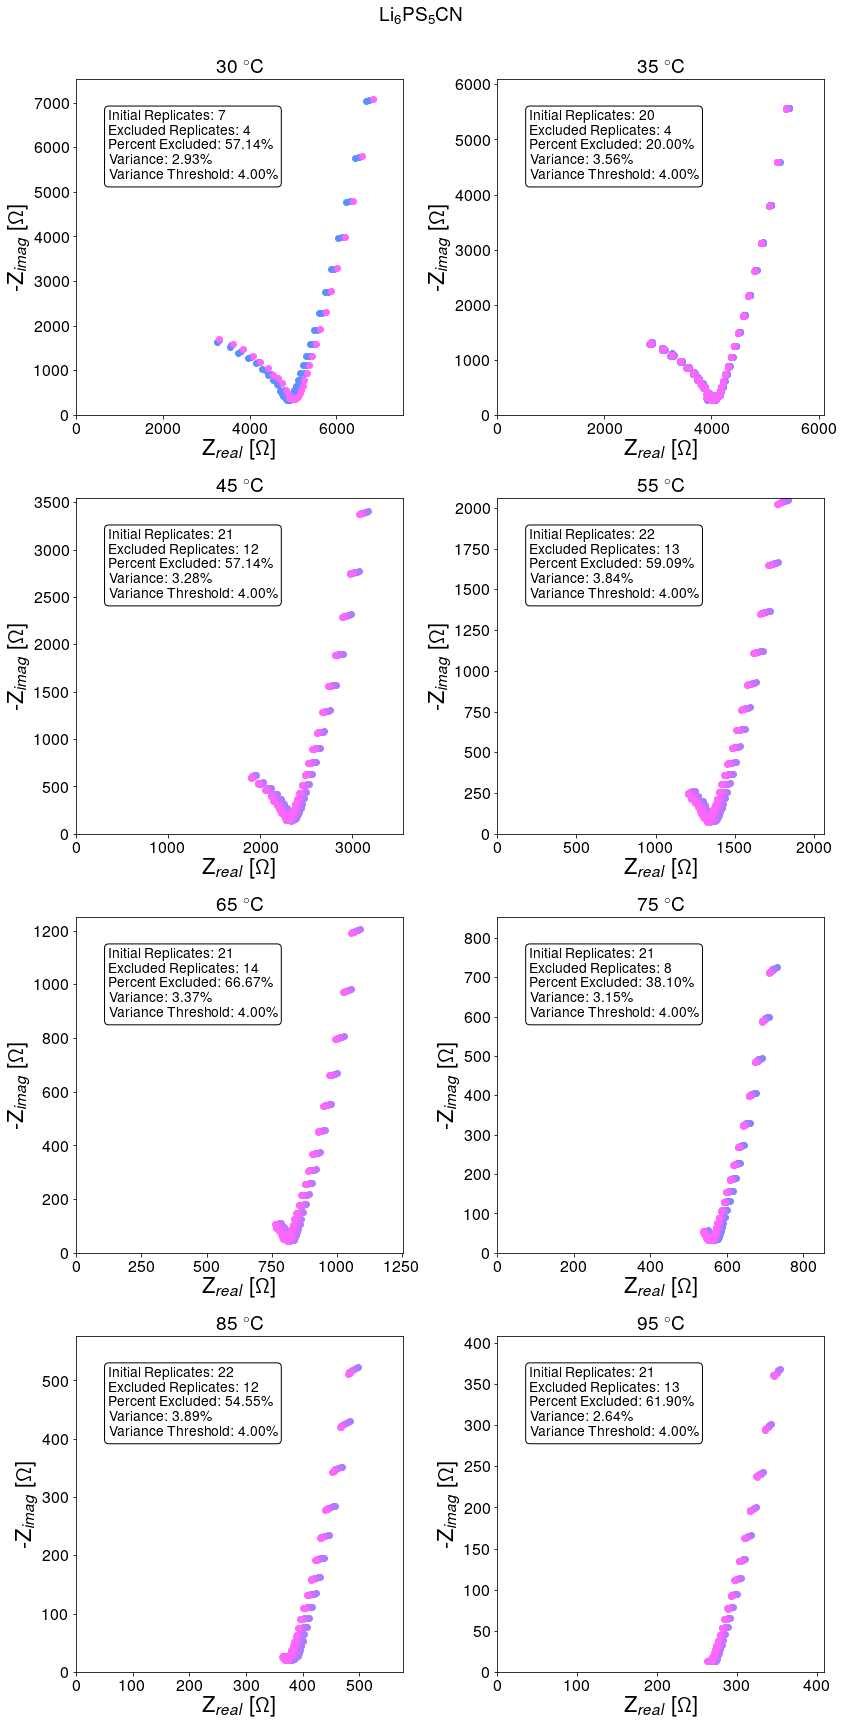

In [12]:
#This cell yeets out datasets starting at the first one collected until the variance falls below a user defined value

from collections import defaultdict
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define `nyquist`, `R1_opt`, `Fs1_opt`, `all_experiments`, and `variance_results` (sample structure)

variance_results = {}
filtered_nyquist = {}
filtered_R1_opt = {}
filtered_Fs1_opt = {}
filtered_all_experiments = {}

# Check if variables are dictionaries
if not isinstance(nyquist, dict):
    raise TypeError("nyquist must be a dictionary")
if not isinstance(R1_opt, dict):
    raise TypeError("R1_opt must be a dictionary")
if not isinstance(Fs1_opt, dict):
    raise TypeError("Fs1_opt must be a dictionary")
if not isinstance(all_experiments, dict):
    raise TypeError("all_experiments must be a dictionary")

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#3399ff", "#ff66ff"])

# Normalize the key[1] values if nyquist is not empty
if nyquist:
    all_keys = [key[1] for key in nyquist.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

# Group the DataFrames by the first element of their keys
grouped_nyquist = defaultdict(list)
for key, df in nyquist.items():
    grouped_nyquist[key[0]].append((key, df))

# Sort dataframes in each group by key[1]
for group_key in grouped_nyquist:
    grouped_nyquist[group_key].sort(key=lambda x: x[0][1])

# Create subplots in a 2-column layout
num_plots = len(grouped_nyquist)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
figsize = (12, 6 * num_rows)
fig0, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

# Function to calculate variance
def calculate_variance(z_real_values):
    return ((max(z_real_values) - min(z_real_values)) / min(z_real_values)) * 100

# User-defined variance threshold
#Change this value as needed
variance_threshold = 4  # Example threshold, modify as needed

# Loop through each group and plot
for ax, (group_key, dataframes) in zip(axes, grouped_nyquist.items()):
    z_real_at_min_z_imag = {}
    filtered_dataframes = dataframes[:]
    original_count = len(dataframes)
    
    # Filter dataframes until variance is below threshold
    while True:
        for i, (key, df) in enumerate(filtered_dataframes):
            # Find index of minimum value in 'Z imag'
            min_index = df['Z imag'].idxmin()
            z_real_at_min_z_imag[key] = df.loc[min_index, 'Z real']
        
        # Calculate percent variance
        var = calculate_variance(list(z_real_at_min_z_imag.values()))
        
        # Break the loop if variance is below threshold or only one dataframe is left
        if var <= variance_threshold or len(filtered_dataframes) == 1:
            break
        
        # Remove the dataframe with the lowest key[1]
        filtered_dataframes.pop(0)
        z_real_at_min_z_imag.clear()
    
    # Store variance results
    variance_results[group_key] = var
    
    # Store filtered nyquist datasets
    for key, df in filtered_dataframes:
        filtered_nyquist[key] = df
    
    # Filter other datasets based on the keys of filtered nyquist datasets
    filtered_keys = set(filtered_nyquist.keys())
    try:
        filtered_R1_opt = {key: value for key, value in R1_opt.items() if key in filtered_keys}
        filtered_Fs1_opt = {key: value for key, value in Fs1_opt.items() if key in filtered_keys}
        filtered_all_experiments = {key: value for key, value in all_experiments.items() if key in filtered_keys}
    except AttributeError as e:
        print(f"Error while filtering: {e}")
        print(f"R1_opt type: {type(R1_opt)}")
        print(f"Fs1_opt type: {type(Fs1_opt)}")
        print(f"all_experiments type: {type(all_experiments)}")
        raise

    # Plot the filtered dataframes
    for i, (key, df) in enumerate(filtered_dataframes):
        color = cmap(norm(key[1])) if i < len(filtered_dataframes) - 1 else "#ff66ff"
        ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color)
    
    # Annotate variance, initial count, and exclusion count on plot
    num_excluded = original_count - len(filtered_dataframes)
    ax.annotate(f'Initial Replicates: {original_count}\nExcluded Replicates: {num_excluded}\nPercent Excluded: {(num_excluded/original_count)*100:.2f}\%\nVariance: {var:.2f}\%\nVariance Threshold: {variance_threshold:.2f}\%', 
                xy=(0.1, 0.7), xycoords='axes fraction', ha='left', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Set limits for each subplot
    if z_real_at_min_z_imag:
        max_value = max(z_real_at_min_z_imag.values())
        limit = max_value * 1.5
        ax.set(xlim=(0, limit), ylim=(0, limit))
        ax.set_xlabel(f'Z$_{{real}}$ [$\Omega$]')
        ax.set_ylabel(f'-Z$_{{imag}}$ [$\Omega$]')
    ax.set_title(f'{group_key} $^\circ$C')

# Hide any unused axes
for i in range(len(grouped_nyquist), len(axes)):
    fig0.delaxes(axes[i])

fig0.suptitle(materialname, y=1)
plt.tight_layout()
plt.show()


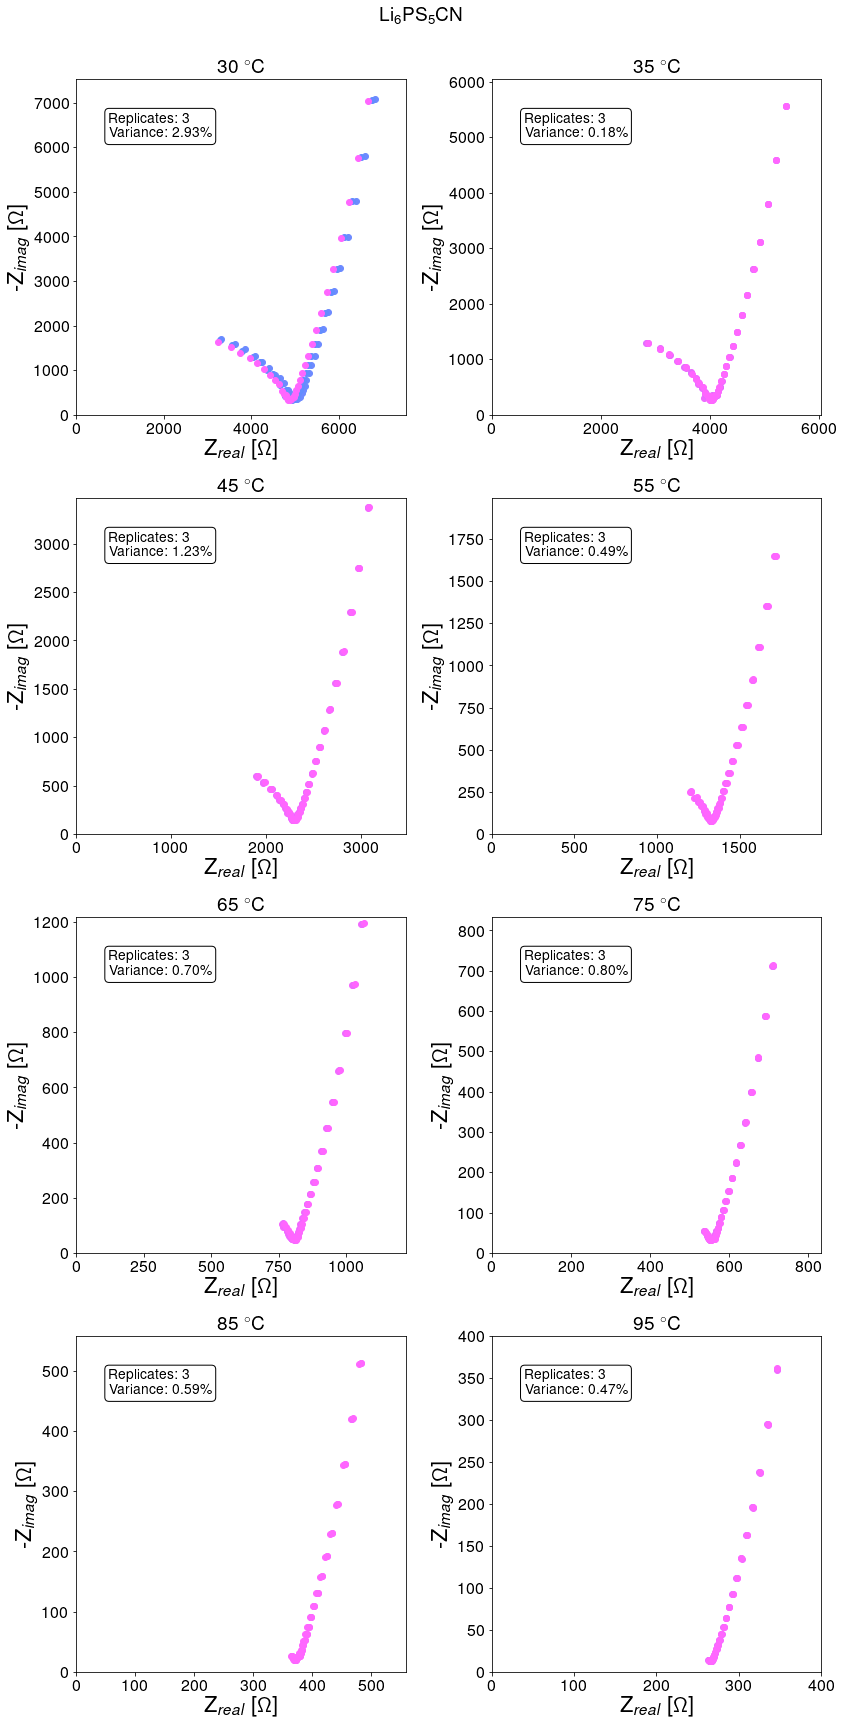

In [13]:
#This cell eliminates all but the last three datasets at each temperature and reports the variance.

from collections import defaultdict
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define `nyquist`, `R1_opt`, `Fs1_opt`, `all_experiments`, and `variance_results` (sample structure)

variance_results = {}
truncated_nyquist = {}
truncated_R1_opt = {}
truncated_Fs1_opt = {}
truncated_all_experiments = {}

# Check if variables are dictionaries
if not isinstance(nyquist, dict):
    raise TypeError("nyquist must be a dictionary")
if not isinstance(R1_opt, dict):
    raise TypeError("R1_opt must be a dictionary")
if not isinstance(Fs1_opt, dict):
    raise TypeError("Fs1_opt must be a dictionary")
if not isinstance(all_experiments, dict):
    raise TypeError("all_experiments must be a dictionary")

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#3399ff", "#ff66ff"])

# Normalize the key[1] values if nyquist is not empty
if nyquist:
    all_keys = [key[1] for key in nyquist.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

# Group the DataFrames by the first element of their keys
grouped_nyquist = defaultdict(list)
for key, df in nyquist.items():
    grouped_nyquist[key[0]].append((key, df))

# Keep only the last three data sets for each group
for group_key in grouped_nyquist:
    grouped_nyquist[group_key].sort(key=lambda x: x[0][1], reverse=True)
    grouped_nyquist[group_key] = grouped_nyquist[group_key][:3]

# Create subplots in a 2-column layout
num_plots = len(grouped_nyquist)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
figsize = (12, 6 * num_rows)
fig0, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

# Function to calculate variance
def calculate_variance(z_real_values):
    return ((max(z_real_values) - min(z_real_values)) / min(z_real_values)) * 100

# Loop through each group and plot
for ax, (group_key, dataframes) in zip(axes, grouped_nyquist.items()):
    z_real_at_min_z_imag = {}
    truncated_dataframes = dataframes[:]
    original_count = len(dataframes)
    
    # Calculate variance
    for i, (key, df) in enumerate(truncated_dataframes):
        # Find index of minimum value in 'Z imag'
        min_index = df['Z imag'].idxmin()
        z_real_at_min_z_imag[key] = df.loc[min_index, 'Z real']
    
    # Calculate percent variance
    var = calculate_variance(list(z_real_at_min_z_imag.values()))
    
    # Store variance results
    variance_results[group_key] = var
    
    # Store truncated nyquist datasets
    for key, df in truncated_dataframes:
        truncated_nyquist[key] = df
    
    # Filter other datasets based on the keys of truncated nyquist datasets
    truncated_keys = set(truncated_nyquist.keys())
    try:
        truncated_R1_opt = {key: value for key, value in R1_opt.items() if key in truncated_keys}
        truncated_Fs1_opt = {key: value for key, value in Fs1_opt.items() if key in truncated_keys}
        truncated_all_experiments = {key: value for key, value in all_experiments.items() if key in truncated_keys}
    except AttributeError as e:
        print(f"Error while filtering: {e}")
        print(f"R1_opt type: {type(R1_opt)}")
        print(f"Fs1_opt type: {type(Fs1_opt)}")
        print(f"all_experiments type: {type(all_experiments)}")
        raise

    # Plot the truncated dataframes
    for i, (key, df) in enumerate(truncated_dataframes):
        color = cmap(norm(key[1])) if i < len(truncated_dataframes) - 1 else "#ff66ff"
        ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color)
    
    # Annotate variance, initial count, and exclusion count on plot
    num_excluded = original_count - len(truncated_dataframes)
    ax.annotate(f'Replicates: {original_count}\nVariance: {var:.2f}\%', 
                xy=(0.1, 0.9), xycoords='axes fraction', ha='left',va='top', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Set limits for each subplot
    if z_real_at_min_z_imag:
        max_value = max(z_real_at_min_z_imag.values())
        limit = max_value * 1.5
        ax.set(xlim=(0, limit), ylim=(0, limit))
        ax.set_xlabel(f'Z$_{{real}}$ [$\Omega$]')
        ax.set_ylabel(f'-Z$_{{imag}}$ [$\Omega$]')
    ax.set_title(f'{group_key} $^\circ$C')

# Hide any unused axes
for i in range(len(grouped_nyquist), len(axes)):
    fig0.delaxes(axes[i])

fig0.suptitle(materialname, y=1)
plt.tight_layout()
plt.show()


In [14]:
#set usefilteredvalues to true if you want to use the data that was filtered to satisfy the variance threshold.

usefilteredvalues=False

if usefilteredvalues==True:
    nyquist=filtered_nyquist
    R1_opt=filtered_R1_opt
    Fs1_opt=filtered_Fs1_opt
    all_experiments=filtered_all_experiments
print(R1_opt)

{(30, 1): 4535.542383887759, (30, 2): 4592.250745227844, (30, 3): 4696.965675843323, (30, 4): 4774.415819364109, (30, 5): 4806.367699949909, (30, 6): 4920.602061364576, (30, 7): 4977.083781776415, (35, 1): 4077.5315324204084, (35, 2): 4077.932565516029, (35, 3): 4076.409357289812, (35, 4): 4074.822505528708, (35, 5): 4071.6956961617257, (35, 6): 4063.2511372207246, (35, 7): 4041.748496441677, (35, 8): 4038.8796856971608, (35, 9): 4038.8796856971608, (35, 10): 4036.540982577108, (35, 11): 4031.968126594343, (35, 12): 4031.680260196957, (35, 13): 4028.2828489557332, (35, 14): 4027.1475565401006, (35, 15): 4027.1475565401006, (35, 16): 4027.1475565401006, (35, 17): 4024.720108297686, (35, 18): 4022.996106800569, (35, 19): 4021.48070899333, (35, 20): 4014.368155114134, (45, 1): 2849.171745755719, (45, 2): 2788.7986170371805, (45, 3): 2735.6700987857253, (45, 4): 2674.6046805081746, (45, 5): 2616.00884954305, (45, 6): 2568.055068596919, (45, 7): 2533.091471024207, (45, 8): 2505.588205248265

In [15]:
#set usetruncatedvalues to true if you want to use the last 3 datasets at each temperature

usetruncatedvalues=True

if usetruncatedvalues==True:
    nyquist=truncated_nyquist
    R1_opt=truncated_R1_opt
    Fs1_opt=truncated_Fs1_opt
    all_experiments=truncated_all_experiments
print(R1_opt)

{(30, 5): 4806.367699949909, (30, 6): 4920.602061364576, (30, 7): 4977.083781776415, (35, 18): 4022.996106800569, (35, 19): 4021.48070899333, (35, 20): 4014.368155114134, (45, 19): 2359.9910414784376, (45, 20): 2352.6714043597963, (45, 21): 2345.872571196672, (55, 20): 1376.4829492890485, (55, 21): 1368.8257244348633, (55, 22): 1365.8555814144436, (65, 19): 860.1520523621175, (65, 20): 860.1520523621175, (65, 21): 860.1520523621175, (75, 19): 586.000050151192, (75, 20): 586.000050151192, (75, 21): 586.000050151192, (85, 20): 386.7840892013419, (85, 21): 386.7840892013419, (85, 22): 386.7840892013419, (95, 19): 278.822884225427, (95, 20): 278.822884225427, (95, 21): 278.822884225427}


In [16]:
#This cell calculates ionic conductivities at each temperature with associated error.

#area calculation

#mm to cm
area = (((diameter)/20)**2)*np.pi
area_err=(((diameter_err)/20)**2)*np.pi
print(area)
#mm to cm
height_cm=height/10
height_cm_err=height_err/10

# Group data by temperature
grouped_R1 = {}
for (temp, replicate), value in R1_opt.items():
    if temp not in grouped_R1:
        grouped_R1[temp] = []
    grouped_R1[temp].append(value)
    

ic={}
ic_err={}
R1={}

for temp, values in grouped_R1.items():
    avg = np.mean(values)
    std_dev = np.std(values)
    R1[temp] = {'average': avg, 'std_dev': std_dev}
    ic[temp]=(1/R1[temp]['average'])*(height_cm/area)
    ic_err[temp]=(math.sqrt(((R1[temp]['std_dev']/R1[temp]['average'])**2)+((height_cm_err/height_cm)**2)+((area_err/area)**2)))*ic[temp]
print(ic)
print(ic_err)



#conductivity calculation (put it in a list then write to a text file)
#for our purposes, this is for exporting the final dataframe
sigma = {}
for key, value in R1_opt.items():
    sigmax = (1/ value)*(height_cm/area)
    sigma[key] = sigmax
    
#print(sigma)    
#print('\u03c3 = {:.2e} S/cm'.format(sigma))

#capacitance calculation
#capacitance = (1/(2*np.pi*R1_opt*fs1_opt))
#print('C = {:.2e} F'.format(capacitance))

0.2827433388230814
{30: 0.0001543485598606812, 35: 0.00018820620830317628, 45: 0.00032153265274071014, 55: 0.0005520454420311281, 65: 0.0008795148416910224, 75: 0.0012909836713636618, 85: 0.00195591420972249, 95: 0.002713251095816926}
{30: 2.237387632220509e-06, 35: 1.9686893222694427e-07, 45: 8.020602177828103e-07, 55: 1.8219024383592688e-06, 65: 4.111876421165764e-07, 75: 6.035560819171606e-07, 85: 9.144220358257847e-07, 95: 1.2684894758730104e-06}


In [17]:
#define confidence interval calculation
#this function calculates the confidence intervals for relevant parameters in the arrhenius fit
def confidence_interval(alpha, x, y, y_fit):
    from scipy import stats
    #calculate the residual errors for the data (r=(y-ypredicted))
    residuals=y-y_fit
    #print('the residual errors are:',residuals)
    k=8.6173303e-5
    #calculate the total residual error (R=sum(y-ypredicted)^2)
    total_residual_error=sum(residuals**2)
    print('the total residual error is:',total_residual_error)
    
    #calculate the standard deviation about the regression (Sr=rt((total residual error)/(n-2))), n= number of data points
    n=len(x)
    print('the number of data points is:',n)
    dof=n-2
    std_dev_reg=math.sqrt(total_residual_error/dof)
    print('the standard deviation about the regression is:',std_dev_reg)
    
    #calculate the standard deviations in the slope and intercept
    meanx=np.mean(x)
    std_dev_slope=std_dev_reg/math.sqrt((sum((x-meanx)**2)))
    std_dev_int=std_dev_reg*math.sqrt((sum(x**2))/(n*sum((x-meanx)**2)))
    print('the standard deviation in the slope is:',std_dev_slope)
    print('the standard deviation in the intercept is:',std_dev_int)
    
    #calculate the student's t-distribution value
    t_val=stats.t.isf(alpha/2,dof)
    print('the t value is:',t_val)
    
    #calculate the confidence intervals for the slope and intercept
    CI_slope=std_dev_slope*t_val
    print('the',(1-alpha)*100,'% confidence interval for the slope is',model.coef_,'+-',CI_slope)
    CI_int=std_dev_int*t_val
    print('the',(1-alpha)*100,'% confidence interval for the intercept is',model.intercept_,'+-',CI_int)
    
    #calculate uncertainty in activation energy (if m=-E/k, uncertainty in E is uncertainty in m*-1*k)
    CI_E=CI_slope*k
    print('the',(1-alpha)*100,'% confidence interval for the activation energy is',E,'+-',CI_E,'eV')
    return(CI_E,CI_int)

In [18]:
#generate two bigboi arrays that are just the temperature and ionic conductivities 
ic_array=np.array([])
ic_err_array=np.array([])
t=np.array([])
for key, data in ic.items():
    ic_array=np.append(ic_array,data)
    temp_part=key
    t=np.append(t,temp_part)
    ic_err_array=np.append(ic_err_array,ic_err[key])
t=t.astype(float) #convert temperature strings into floats

print(t,ic_array,ic_err_array)

#manipulate the temperature for our purposes
t_k=t+273.15 #convert to kelvin
tinv=1/t_k #go to inverse temperature for the plotting
x=tinv.reshape((-1,1)) #reshape tinv to being 1 column for the purposes of the fitting

#calculate the natural log of ionic conductivity times temperature. made new variable named y for simplicity in later code
log_ic_t=np.log(ic_array*t_k)
y=log_ic_t #make a new variable called y because y not?

#calculate relative error in the data points, used to weight the fit.
y_err_weighting=(ic_err_array)/(ic_array)

k=8.6173303e-5

#now we do a linear fit of the data, y=mx+b, where ln(ic*T)=y, -E/k=m, 1/T=x,ln(A)=b
model=LinearRegression()
model.fit(x,y,sample_weight=1/y_err_weighting)

#call and print the r^2 value of the fit
r_sq=model.score(x,y,sample_weight=1/y_err_weighting)
print('r^2 value of the fit:',r_sq)

#call and print the y intercept (ln(A))
print('y intercept:',model.intercept_)

#call and print the slope (-E/k)
print('slope:',model.coef_)

#calculate activation energy via m=-E/k-->-m*k=E
E=-1*model.coef_*k
print('the calculated activation energy is:',E,'eV')

#calculate the error values
CI_E,CI_int=confidence_interval(0.05,x,y,model.predict(x))

[30. 35. 45. 55. 65. 75. 85. 95.] [0.00015435 0.00018821 0.00032153 0.00055205 0.00087951 0.00129098
 0.00195591 0.00271325] [2.23738763e-06 1.96868932e-07 8.02060218e-07 1.82190244e-06
 4.11187642e-07 6.03556082e-07 9.14422036e-07 1.26848948e-06]
r^2 value of the fit: 0.9986345286471592
y intercept: 14.598197716402577
slope: [-5361.05830556]
the calculated activation energy is: [0.4619801] eV
the total residual error is: 0.008043401594028225
the number of data points is: 8
the standard deviation about the regression is: 0.03661375332218806
the standard deviation in the slope is: 65.41815982443346
the standard deviation in the intercept is: 0.19727194683523935
the t value is: 2.446911848791681
the 95.0 % confidence interval for the slope is [-5361.05830556] +- 160.07247040055415
the 95.0 % confidence interval for the intercept is 14.598197716402577 +- 0.48270706414534975
the 95.0 % confidence interval for the activation energy is [0.4619801] +- 0.013793973493785484 eV


In [19]:
#prefactor fun-- we are going to calculate the prefactor and confidence interval here!

#calculate the relative confidence interval in log terms
rel_interval=CI_int/model.intercept_
prefactor=exp(model.intercept_)
absolute_error=prefactor*rel_interval

print(f'the prefactor is {prefactor}({absolute_error}) KS/cm')

the prefactor is 2187342.1101735933(72327.11248300456) KS/cm


In [20]:
#calculate 30 degree conductivity and 95% confidence interval

def conductivity_confidence_interval(temp, alpha):
    from scipy import stats
    floattemp=float(temp)
    for key, value in ic.items():
        temp_part=float(key)
        if temp_part==floattemp:
            print(floattemp,'C mean conductivity is:', value, 'S/cm')
            conductivity=value
    std_dev=ic_err[temp]
    
    print('Standard deviation of the conductivities at', floattemp,'C is:', std_dev, 'S/cm')
    
    counter={}
    for key, value in R1_opt.items():
        temp_part=float(key[0])
          # Check if the temperature part is already a key in mean_conductivities
        if temp_part in counter:
            # If it is, add the conductivity value to the existing list
            counter[temp_part].append(value)
            #print('I added something to the counter')
        else:
            # If it's not, create a new entry with a list containing the current resistance value
            counter[temp_part] = [value]
            
    for conductivity_list in counter.items():
        num_rep=len(counter[floattemp])
    print('the number of replicates for',floattemp,'C is:',num_rep)
    dof=num_rep-1
    t_val=stats.t.isf(alpha/2,dof)
    print('t-value is',t_val)
    #moe= margin of error
    moe=(t_val*std_dev)/(sqrt(num_rep))
    return(conductivity, moe)

alpha=0.05
conductivity, moe=conductivity_confidence_interval(30,alpha)

cond_mS=conductivity*1000
moe_mS=moe*1000

print('The',((1-alpha)*100),'% confidence interval for the ionic conductivity is',cond_mS,'+-',moe_mS,'mS/cm')

30.0 C mean conductivity is: 0.0001543485598606812 S/cm
Standard deviation of the conductivities at 30.0 C is: 2.237387632220509e-06 S/cm
the number of replicates for 30.0 C is: 3
t-value is 4.3026527299112765
The 95.0 % confidence interval for the ionic conductivity is 0.15434855986068122 +- 0.005557978993211769 mS/cm


In [21]:
#Calculate ln(sigmaT) values

#define T values in Kelvin
Kelvin_temp = [x + 273 for x in target_temperatures]
print(Kelvin_temp)

relative_error={}
for temp in target_temperatures:
     relative_error[temp]=(ic_err[temp])/(ic[temp])

# Create a DataFrame, std dev log is actually a 95% confidence interval but I was too lazy to actually 
finaldf = pd.DataFrame({
    'T': (1 / temp for temp in Kelvin_temp),
    'LnsigmaT': [np.log(ic[temp] * (temp + 273)) for temp in target_temperatures],
    'std_dev_log':[abs(relative_error[temp]*np.log(ic[temp] * (temp + 273))) for temp in target_temperatures]
})
print(finaldf)

[303, 308, 318, 328, 338, 348, 358, 368]
          T  LnsigmaT   std_dev_log
0  0.003300 -3.062564  4.439396e-02
1  0.003247 -2.847873  2.978954e-03
2  0.003145 -2.280360  5.688337e-03
3  0.003049 -1.708867  5.639732e-03
4  0.002959 -1.213094  5.671415e-04
5  0.002874 -0.800148  3.740825e-04
6  0.002793 -0.356365  1.666063e-04
7  0.002717 -0.001525  7.128497e-07


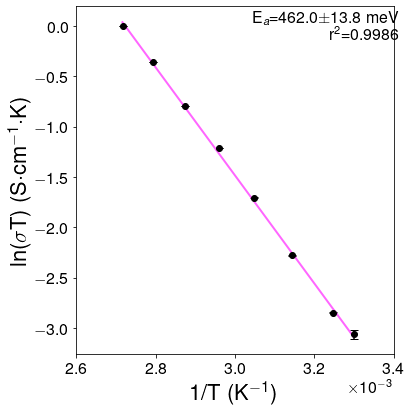

In [22]:
# Perform linear regression
#slope, intercept, r_value, p_value, std_err = linregress(finaldf['T'], finaldf['LnsigmaT'])

#set the figure size
plt.figure(figsize=(6,6))
plt.xlim(0.0026,0.0034)
blue='#3399ff'
pink='#ff66ff'

# Plotting the data and the regression line
plt.errorbar(finaldf['T'], finaldf['LnsigmaT'], yerr=finaldf['std_dev_log'],xerr=None,color='black', linestyle='none',marker='o',capsize=4)
plt.plot(x,model.predict(x),color=pink,linestyle='solid',linewidth=2)

plt.ylabel(r'ln($\sigma$T) (S$\cdot$cm$^{-1}\cdot$K)')
plt.xlabel('1/T (K$^{-1}$)')
E_mev_round=np.around(E*1000,1)
E_mev_round=''.join(map(str,E_mev_round))

CI_E_mev_round=np.around(CI_E*1000,1)

r_sq_round=np.around(r_sq,4)

showr2='yes'

if showr2=='yes':
    plotlabel=''.join(('E$_a$=',E_mev_round,r'$\pm$',str(CI_E_mev_round),' meV','\nr$^2$=',str(r_sq_round)))
else:              
    plotlabel=''.join(('\n','E$_a$=',E_mev_round,r'$\pm$',str(CI_E_mev_round), ' meV'))

plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))

plt.figtext(0.95,0.95,plotlabel ,horizontalalignment='right',verticalalignment='top',)
plt.tight_layout()

#THIS IS WHERE THE ARRHENIUS AND SUMMARY DATA WILL BE SAVED
saveloc_DIR='/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_1/Arrhenius'

subfolds=''

#filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), materialname)

# filter returns a generator, so we need to re-join the string
cleaned_matname = "".join(cleaned_matname)

saveloc=''.join((saveloc_DIR,subfolds))
if not os.path.isdir(saveloc):
        os.makedirs(saveloc_DIR)
plot_filename=''.join((saveloc,'/',samplename,' ',cleaned_matname,' Arrhenius_Plot.png'))
plt.savefig(plot_filename,dpi=300, bbox_inches="tight")

plt.show()



# Set the fontsize of the tick labels


# Displaying the legend
#plt.legend()

# Show the plot

# Display regression statistics
#print(f"Slope: {slope}")
#print(f"Intercept: {intercept}")
#print(f"R-squared value: {r_value**2}")
#print(f"P-value: {p_value}")

In [23]:
#Generate a pandas dataframe with all the relevant parameters from the fit

#modify samplename and materialname as appropriate
samplename='2_089_1 last 3 datasets'
materialname='Li$_6$PS$_5$CN'

slope=[float(model.coef_)]*len(finaldf)
intercept=[model.intercept_]*len(finaldf)
Ea=[float(E)]*len(finaldf)
CI_Ea=[CI_E]*len(finaldf)
samplenamez=[samplename]*len(finaldf)
materialnamez=[materialname]*len(finaldf)
r_sqs=[r_sq]*len(finaldf)
conductivityz=[conductivity]*len(finaldf)
moez=[moe]*len(finaldf)
moez_prefactor=[absolute_error]*len(finaldf)
meanz_prefactor=[prefactor]*len(finaldf)

exportdf = pd.DataFrame({
    'T':target_temperatures,
    '1/T': finaldf['T'],
    'LnsigmaT': finaldf['LnsigmaT'],
    'std_dev_ln':finaldf['std_dev_log'],
    'slope':slope,
    'intercept':intercept,
    'r_squared':r_sqs,
    'Ea':Ea,
    'CI_Ea':CI_Ea,
    'sample_name':samplenamez,
    'material_name':materialnamez,
    '30c conductivity':conductivityz,
    '30c conductivity MOE':moez,
    'Prefactor':meanz_prefactor,
    'Prefactor MOE':moez_prefactor
})

print(exportdf)



    T       1/T  LnsigmaT    std_dev_ln        slope  intercept  r_squared  \
0  30  0.003300 -3.062564  4.439396e-02 -5361.058306  14.598198   0.998635   
1  35  0.003247 -2.847873  2.978954e-03 -5361.058306  14.598198   0.998635   
2  45  0.003145 -2.280360  5.688337e-03 -5361.058306  14.598198   0.998635   
3  55  0.003049 -1.708867  5.639732e-03 -5361.058306  14.598198   0.998635   
4  65  0.002959 -1.213094  5.671415e-04 -5361.058306  14.598198   0.998635   
5  75  0.002874 -0.800148  3.740825e-04 -5361.058306  14.598198   0.998635   
6  85  0.002793 -0.356365  1.666063e-04 -5361.058306  14.598198   0.998635   
7  95  0.002717 -0.001525  7.128497e-07 -5361.058306  14.598198   0.998635   

        Ea     CI_Ea              sample_name   material_name  \
0  0.46198  0.013794  2_089_1 last 3 datasets  Li$_6$PS$_5$CN   
1  0.46198  0.013794  2_089_1 last 3 datasets  Li$_6$PS$_5$CN   
2  0.46198  0.013794  2_089_1 last 3 datasets  Li$_6$PS$_5$CN   
3  0.46198  0.013794  2_089_1 last 3 

In [24]:
#save the dataframe generated in the previous cell

#filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), materialname)

# filter returns a generator, so we need to re-join the string
cleaned_matname = "".join(cleaned_matname)

#THIS IS WHERE THE ARRHENIUS AND SUMMARY DATA WILL BE SAVED
saveloc_DIR='/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_1/Arrhenius'

subfolds=''

saveloc=''.join((saveloc_DIR,subfolds))

filename=''.join((saveloc,'/',samplename,' ',cleaned_matname,' Arrhenius and Summary Plot.csv'))
plot_filename=''.join((saveloc,'/',samplename,' ',cleaned_matname,' Arrhenius_Plot.png'))
readytosave=True

if readytosave==True:
    if not os.path.isdir(saveloc):
        os.makedirs(saveloc_DIR)
    exportdf.to_csv(filename)




,$T$ ($^\circ$C),&,Replicate Scan,&,R$_0$ ($\Omega$),&,$R_1$ ($\Omega$),&,$\sigma$ (S cm$^{-1}$),&,...,$Q_1$(S/s$^n$),&,$C_1$ (F),&,$\tau_{1}$ (Hz),&,$n_2$,&,$Q_2$(S/s$^n$),\\
0,30,&,1,&,9.99e-01,&,4.81e+03,&,1.57e-04,&,...,1.76e-10,&,9.45e-12,&,3.50e+06,&,0.79,&,1.92e-07,\\
1,30,&,2,&,1.00e+00,&,4.92e+03,&,1.54e-04,&,...,2.21e-10,&,9.50e-12,&,3.41e+06,&,0.80,&,1.89e-07,\\
2,30,&,3,&,9.99e-01,&,4.98e+03,&,1.52e-04,&,...,2.05e-10,&,9.41e-12,&,3.40e+06,&,0.79,&,1.89e-07,\\
3,35,&,1,&,9.34e-01,&,4.02e+03,&,1.88e-04,&,...,2.28e-10,&,9.50e-12,&,4.16e+06,&,0.81,&,1.84e-07,\\
4,35,&,2,&,9.94e-01,&,4.02e+03,&,1.88e-04,&,...,2.35e-10,&,9.56e-12,&,4.14e+06,&,0.81,&,1.82e-07,\\
5,35,&,3,&,4.71e-01,&,4.01e+03,&,1.88e-04,&,...,2.19e-10,&,9.57e-12,&,4.14e+06,&,0.80,&,2.03e-07,\\
6,45,&,1,&,1.27e-02,&,2.36e+03,&,3.21e-04,&,...,6.05e-10,&,9.07e-12,&,7.43e+06,&,0.89,&,8.41e-08,\\
7,45,&,2,&,5.29e-05,&,2.35e+03,&,3.22e-04,&,...,6.17e-10,&,9.18e-12,&,7.37e+06,&,0.89,&,8.35e-08,\\
8,45,&,3,&,2.05e-04,&,2.35e+03,&,3.22e-04,&,...,6.46e-10,&,9.06e-12,&,7.49e+06,&,0.89,&,8.28e-08,\\
9,55,&,1,&,3.16e-05,&,1.38e+03,&,5.50e-04,&,...,1.95e-09,&,7.56e-12,&,1.53e+07,&,0.90,&,8.94e-08,\\


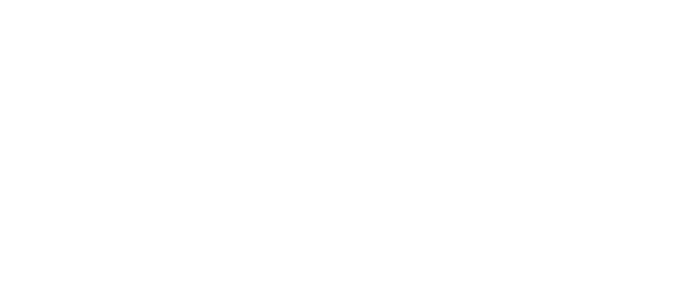

In [25]:
#This cell generates a table of echem data that can be pasted into latex!

#leading resistor
R1={}
#parallel Resistor
R2={}
#parallel constant phase element
Q2={}
n2={}
#tailing constant phase element
Q3={}
n3={}

capacitance={}
char_freq={}

for key, exp_instance in all_experiments.items():
    R1[key]=float(exp_instance.fit_Rs[0])
    R2[key]=float(exp_instance.fit_R1[0])
    n2[key]=float(exp_instance.fit_n1[0])
    Q2[key]=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0])
    capacitance[key]=(((Q2[key]*R2[key])**(1/n2[key]))/R2[key])
    char_freq[key]=float(exp_instance.fit_fs1[0])
    n3[key]=float(exp_instance.fit_n[0])
    Q3[key]=float(exp_instance.fit_Q[0])
    
    
#print(R2)
# Create a mapping from old keys to new keys

new_keys_mapping = {}
counters = {}

for key in R2.keys():
    if key[0] not in counters:
        counters[key[0]] = 1
    new_keys_mapping[key] = (key[0], counters[key[0]])
    counters[key[0]] += 1

# Function to reindex dictionaries based on new_keys_mapping
def reindex_dict(original_dict):
    new_dict = {}
    for old_key, value in original_dict.items():
        new_key = new_keys_mapping[old_key]
        new_dict[new_key] = value
    return new_dict

# Reindex all dictionaries
R1_new = reindex_dict(R1)
R2_new = reindex_dict(R2)
n2_new = reindex_dict(n2)
Q2_new = reindex_dict(Q2)
n3_new = reindex_dict(n3)
Q3_new = reindex_dict(Q3)
sigma_new=reindex_dict(sigma)
capacitance_new=reindex_dict(capacitance)
char_freq_new=reindex_dict(char_freq)
reindexed_experiments=reindex_dict(all_experiments)

#print(reindexed_experiments)
#print(R2_new)

# Combine reindexed dictionaries into a single DataFrame
refinedparams = {
    r'$T$ ($^\circ$C)': [key[0] for key in R1_new.keys()],
    'Replicate Scan': [key[1] for key in R1_new.keys()],
    r'R$_0$ ($\Omega$)': list(R1_new.values()),
    r'$R_1$ ($\Omega$)': list(R2_new.values()),
    r'$\sigma$ (S cm$^{-1}$)':list(sigma_new.values()),
    r'$n_1$': list(n2_new.values()),
    r'$Q_1$(S/s$^n$)': list(Q2_new.values()),
    r'$C_1$ (F)': list(capacitance_new.values()),
    r'$\tau_{1}$ (Hz)': list(char_freq_new.values()),
    r'$n_2$': list(n3_new.values()),
    r'$Q_2$(S/s$^n$)': list(Q3_new.values())
    
}

refinedparams = pd.DataFrame(refinedparams)


# Create a figure and add the DataFrame as a table
fig, ax = plt.subplots(figsize=(12, 5))  # Set the figure size as needed
ax.axis('off')  # Hide the axes

#roundedrefinedparams=refinedparams.round(2)
def scientific_notation(x):
    return f"{x:.2e}"


columns_to_sci = [r'R$_0$ ($\Omega$)',r'$R_1$ ($\Omega$)',r'$Q_1$(S/s$^n$)',r'$C_1$ (F)',r'$Q_2$(S/s$^n$)',r'$\sigma$ (S cm$^{-1}$)',r'$\tau_{1}$ (Hz)']
refinedparams[columns_to_sci] = refinedparams[columns_to_sci].applymap(scientific_notation)
columns_to_round=[r'$n_1$',r'$n_2$']
refinedparams[columns_to_round]=refinedparams[columns_to_round].round(2)
#Add '&' columns and '\' at the end of each row
for col in refinedparams.columns[:-1]:
    refinedparams.insert(refinedparams.columns.get_loc(col)+1, '&', '&',allow_duplicates=True)

# Add the '\\' column at the end
refinedparams['\\\\'] = '\\\\'
display(refinedparams)
# Add the table to the plot
#table = ax.table(cellText=refinedparams.values, colLabels=refinedparams.columns, cellLoc='center', loc='center')
#ax.set_title(materialname)
# Initialize a list to store formatted rows
formatted_rows = []

# Loop through each row in the DataFrame
#for _, row in refinedparams.iterrows():
    # Join each row value with '&', then add '\\' at the end
    #formatted_row = ' & '.join(row.astype(str)) + r' \\'
    #formatted_rows.append(formatted_row)

# Combine all rows into the final table string
#latex_table = '\n'.join(formatted_rows)

# Print the LaTeX table string
#print(latex_table)
# Style the table
#table.auto_set_font_size(False)
#table.autofit=True
#table.set_fontsize(10)
#table.scale(1.2, 1.2)  # Adjust the scaling as needed

#plt.show()

#this is the repository for all our temp dependent nyquists!
params_saveloc_DIR='/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_1/parameters'
#this will be the folder into which we whang all of the dataframes, named based on the sample and material name
params_filename=f"{samplename}_{cleaned_matname}_refinedparameters.csv"


#here we save all of our dataframes! don't want to miss out on any yummy data, so we save it all
#the save format is temp_30_replicate_1_1-107A Pellet 2_SSM Li6PS5Cl, obviously different if your materials aren't exactly like mine
readytosave=True
if readytosave==True:
    if not os.path.isdir(params_saveloc_DIR):
        os.makedirs(params_saveloc_DIR)
    refinedparams.to_csv(f"{params_saveloc_DIR}/{params_filename}")


In [26]:
#in this cell, we generate simulated data for each nyquist plot so as to be able to export experimental and modeled values
#for temperature dependent nyquist plots

#generates a frequency range for any simulations
f_range = freq_gen(f_start=(2*10**6), f_stop=0.2, pts_decade=10)
print(f_range[0][:4]) #First 5 points in the freq. array
print()
print(f_range[1][:4]) #First 5 points in the angular freq. array


#This chunk of code generates a simulated dataset using the parameters from the initial modelling above
sim={}

# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in reindexed_experiments.items():
        sim_temp= cir_RsRQQ(w=f_range[1], Rs=float(exp_instance.fit_Rs[0]), R1=float(exp_instance.fit_R1[0]), n1=float(exp_instance.fit_n1[0]), Q1=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0]), n=float(exp_instance.fit_n[0]), Q=float(exp_instance.fit_Q[0]))
        sim[key]=sim_temp
        

[2000000.         1583363.8318526  1253520.51200948  992389.52060058]

[12566370.61435917  9948568.36421585  7876101.66330618  6235367.25483656]


In [27]:

    
#here we make a bunch of dataframes with all of the info we need for nyquist plots
nyquistdf={}
# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in reindexed_experiments.items():
        min_length = min(len(exp_instance.df_raw.re), len(exp_instance.df_raw.im), len(sim[key].real), len(sim[key].imag),len(exp_instance.df_raw.f))
        key_temp=[key]*min_length
        samplenamez=[samplename]*min_length
        materialnamez=[materialname]*min_length
        diameterz=[diameter]*min_length
        heightz=[height]*min_length
        # Truncate arrays to the minimum length
        truncated_re = exp_instance.df_raw.re[:min_length]
        truncated_im = exp_instance.df_raw.im[:min_length]
        truncated_f= exp_instance.df_raw.f[:min_length]
        truncated_fit_real = sim[key].real[:min_length]
        truncated_fit_imag = -sim[key].imag[:min_length]
        
        # Create DataFrame with truncated arrays
        nyquistdf[key] = pd.DataFrame({
            'Frequency':truncated_f,
            'Z real': truncated_re,
            'Z imag': truncated_im,
            'Fit real': truncated_fit_real,
            'Fit imag': truncated_fit_imag,
            'Dataset':key_temp,
            'sample_name':samplenamez,
            'material_name':materialnamez,
            'height':heightz,
            'diameter':diameterz
        })
print(nyquistdf)
#this is the repository for all our temp dependent nyquists!
nyquist_saveloc_DIR='/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_1/T_dep_Nyquists'
#this will be the folder into which we whang all of the dataframes, named based on the sample and material name
save_location=''.join((nyquist_saveloc_DIR,'/',samplename,' ',cleaned_matname))


#here we save all of our dataframes! don't want to miss out on any yummy data, so we save it all
#the save format is temp_30_replicate_1_1-107A Pellet 2_SSM Li6PS5Cl, obviously different if your materials aren't exactly like mine
readytosave=True
if readytosave==True:
    for key,df in nyquistdf.items():
        filename=f"temp_{key[0]}_replicate_{key[1]}_{samplename}_{cleaned_matname}.csv"
        if not os.path.isdir(save_location):
            os.makedirs(save_location)
        df.to_csv(f"{save_location}/{filename}")


{(30, 1):        Frequency       Z real       Z imag      Fit real      Fit imag  \
0   2.000039e+06     3251.348     1634.487  3.245763e+03  1.692392e+03   
1   1.588711e+06     3539.950     1518.312  3.544358e+03  1.566438e+03   
2   1.261992e+06     3744.275     1385.451  3.800661e+03  1.419282e+03   
3   1.002539e+06     3973.033     1284.011  4.013785e+03  1.263734e+03   
4   7.962891e+05     4145.222     1155.898  4.186772e+03  1.110187e+03   
..           ...          ...          ...           ...           ...   
65  6.334459e-01   951708.000  2501973.000  6.811414e+05  1.964047e+06   
66  5.029507e-01  1162447.000  2970346.000  8.179969e+05  2.361470e+06   
67  3.999573e-01  1411707.000  3514947.000  9.825448e+05  2.839310e+06   
68  3.175813e-01  1710265.000  4163312.000  1.180389e+06  3.413841e+06   
69  2.520161e-01  2066169.000  4930465.000  1.418266e+06  4.104628e+06   

    Dataset              sample_name   material_name  height  diameter  
0   (30, 1)  2_089_1 last 3 